In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Here is the medical costs dataset from previous modules
# We use the numeric variables and the smoker variable to predict charges, using both KNN and OLS regressions.

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from medicalcosts',con=engine)

engine.dispose()


df.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860
5,31,female,25.740,0,no,southeast,3756.620
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.510
8,37,male,29.830,2,no,northeast,6406.410
9,60,female,25.840,0,no,northwest,28923.100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df['is_smoker'] = pd.get_dummies(df.smoker, drop_first=True)

# Y is the target variable
Y = df['charges']
# X is the feature set
X = df[['age', 'bmi', 'children','is_smoker']]

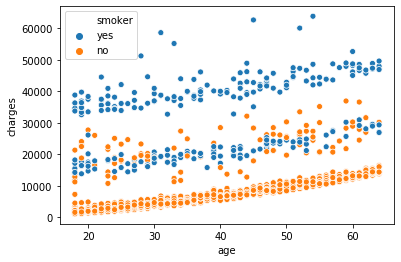

In [6]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=df)
plt.show()

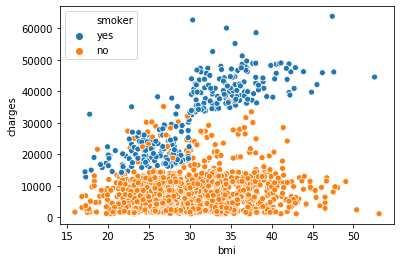

In [7]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.show()

In [8]:
# Since 'smoker' has a strong impact on medical costs and is 0 or 1, we normalize the two other numeric features first.
# Here we use a shift and rescale normalization (i.e. applying a linear function so that values fall between 0 and 1)
# This is only important for the KNN regression model

X = (X - X.min()) / (X.max() - X.min())

In [9]:
X1 = sm.add_constant(X.copy())

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X1).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     998.1
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:03:28   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2324.7289    507.172     -4.584      0.0

In [11]:
# We fit an OLS model using sklearn to get cross
lrm = LinearRegression()
lrm.fit(X, Y)

Y_preds = lrm.predict(X)

score = cross_val_score(lrm, X, Y, cv=5)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.76148169 0.7087821  0.77626513 0.73135292 0.75675099]
Accuracy: 0.75 (+/- 0.05)


In [12]:
# We fit two KNN regression models using sklearn and get cross validation scores with five folds.
# The second model is distance-weighted
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X, Y)

knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X, Y)

scoreknn = cross_val_score(knn, X, Y, cv=5)
print(scoreknn)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (scoreknn.mean(), scoreknn.std() * 2))
scoreknn_w = cross_val_score(knn_w, X, Y, cv=5)
print(scoreknn_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (scoreknn_w.mean(), scoreknn_w.std() * 2))

[0.85122515 0.77576312 0.83901355 0.80564735 0.81667709]
Unweighted Accuracy: 0.82 (+/- 0.05)
[0.82210655 0.75099972 0.82950566 0.80277378 0.80910682]
Weighted Accuracy: 0.80 (+/- 0.06)


The unweighted KNN regression model is best so far in terms of accuracy. It is tied with OLS for variance. We try changing the the number of neighbors.

In [13]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X, Y)

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X, Y)

scoreknn = cross_val_score(knn, X, Y, cv=5)
print(scoreknn)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (scoreknn.mean(), scoreknn.std() * 2))
scoreknn_w = cross_val_score(knn_w, X, Y, cv=5)
print(scoreknn_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (scoreknn_w.mean(), scoreknn_w.std() * 2))

[0.85335329 0.78177644 0.86026193 0.8199522  0.82252533]
Unweighted Accuracy: 0.83 (+/- 0.06)
[0.83453759 0.76477143 0.85529827 0.81794916 0.81933115]
Weighted Accuracy: 0.82 (+/- 0.06)


In [14]:
knn = neighbors.KNeighborsRegressor(n_neighbors=8)
knn.fit(X, Y)

knn_w = neighbors.KNeighborsRegressor(n_neighbors=8, weights='distance')
knn.fit(X, Y)

scoreknn = cross_val_score(knn, X, Y, cv=5)
print(scoreknn)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (scoreknn.mean(), scoreknn.std() * 2))
scoreknn_w = cross_val_score(knn_w, X, Y, cv=5)
print(scoreknn_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (scoreknn_w.mean(), scoreknn_w.std() * 2))

[0.85294542 0.78356645 0.85891178 0.81928408 0.82199201]
Unweighted Accuracy: 0.83 (+/- 0.05)
[0.83174058 0.76277793 0.85131777 0.81519809 0.81657701]
Weighted Accuracy: 0.82 (+/- 0.06)


Unweighted KNN with 8 neighbors is the best in terms of accuaracy and variance from all of the above models. All of the above models (including OLS) seem to "miss" the most on the second fold. KNN-regression would likely be worse here without first normalizing the data. Without the smoker feature period, OLS would probably likely be the better candidate. This is because every value in the smoker column is the extreme 0 or 1, while the other features are are (likely) normally distributed in 0 to 1.